## How to statistically evaluate your data from ensemble runs:

First, make sure, we are in the right place.

In [136]:
%%px
import os
import pymofa
from pymofa.experiment_handling import experiment_handling as eh
import numpy as np
import pandas as pd

print(os.path.abspath(pymofa.__file__))

def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return root
path = find('03_EnsembleEvaluation.ipynb', '/home/')
print(path)
os.chdir(path)
print(os.getcwd())

[stdout:0] 
/home/jakob/Project_PyMofa/tutorial/pymofa/__init__.pyc
/home/jakob/Project_PyMofa/tutorial
/home/jakob/Project_PyMofa/tutorial
[stdout:1] 
/home/jakob/Project_PyMofa/tutorial/pymofa/__init__.pyc
/home/jakob/Project_PyMofa/tutorial
/home/jakob/Project_PyMofa/tutorial
[stdout:2] 
/home/jakob/Project_PyMofa/tutorial/pymofa/__init__.pyc
/home/jakob/Project_PyMofa/tutorial
/home/jakob/Project_PyMofa/tutorial


Given, that you whent through the second tutorial, there should be some results to work with already.

In [137]:
%%px
import os
SAVE_PATH_RAW = "./dummy/pymofatutorial"
print(os.listdir(SAVE_PATH_RAW)[0:5])

[stdout:0] ['0o1-0o1-1o0_s0.pkl', '0o1-0o1-1o0_s3.pkl', '0o1-0o1-1o0_s4.pkl', '0o1-0o1-1o0_s1.pkl', '0o1-0o1-1o0_s2.pkl']
[stdout:1] ['0o1-0o1-1o0_s0.pkl', '0o1-0o1-1o0_s3.pkl', '0o1-0o1-1o0_s4.pkl', '0o1-0o1-1o0_s1.pkl', '0o1-0o1-1o0_s2.pkl']
[stdout:2] ['0o1-0o1-1o0_s0.pkl', '0o1-0o1-1o0_s3.pkl', '0o1-0o1-1o0_s4.pkl', '0o1-0o1-1o0_s1.pkl', '0o1-0o1-1o0_s2.pkl']


Now, we want to do some MPI accelerated statistical analysis with this data using the resave routine of the experiment_handle class from pymofa.
Therefore, again, we need to start an *ipcontroller* and some *engines* for ipyparallel

$ipcluster

$mpirun-n [number of engines] ipengine --mpi=mpi4py

and connect to them with the IPython kernel

In [138]:
from ipyparallel import Client
c = Client()

Then, we need to to setup the experiment handle from the previous experiment again, only that this time, we will pass the experiment handle the optional path to create a folder for results (different from the one for the raw data)

In [141]:
%%px

import itertools as it
import glob as g
import os
from pymofa.experiment_handling import experiment_handling as eh

#Definingh the experiment execution function
#it gets paramater you want to investigate, plus `filename` as the last parameter
def RUN_FUNC(prey_birth_rate, coupling, predator_death_rate, initial_pop, time_length,
             filename):
    """Dummy RUN_FUNC just to make the INDEX (below) work."""
    
    exit_status = 42
    randomvarname = 'bla'

    return exit_status 

# Path where to Store the simulated Data
SAVE_PATH_RAW = "./dummy/pymofatutorial/"

#path to folder for results of statistical evaluation
SAVE_PATH_RES = "./dummy/stateval_results/"

# Parameter combinations to investiage
#prey_birth_rate = [0.09, 0.1, 0.11]
#coupling = [0.1]
#predator_death_rate = [0.005, 0.01, 0.05, 0.1]
#initial_pop = [1.0, 2.0]
#time_length = [1000]

prey_birth_rate = [0.1]
predator_death_rate = [0.1]
initial_pop = [1.]

PARAM_COMBS = list(it.product(prey_birth_rate, predator_death_rate, initial_pop))

# Sample Size
SAMPLE_SIZE = 5

# INDEX 
INDEX = {0: 'prey_birth_rate', 1: 'predator_death_rate', 2: 'initial_pop'}
print(INDEX)

# initiate handle instance with experiment variables
handle = eh(SAMPLE_SIZE, PARAM_COMBS, INDEX, SAVE_PATH_RAW, SAVE_PATH_RES)

[stdout:0] {0: 'prey_birth_rate', 1: 'predator_death_rate', 2: 'initial_pop'}
[stdout:1] {0: 'prey_birth_rate', 1: 'predator_death_rate', 2: 'initial_pop'}
[stdout:2] {0: 'prey_birth_rate', 1: 'predator_death_rate', 2: 'initial_pop'}


The resave routine of this experiment handle requires a dictionary of callables and a filename for the results as inputs. The experiment handle keeps track of the simulation results internally in a list of filenames that is required as an input to the callables passed to the resave routine.

Note, that the callables are designed to handle Pandas Dataframes. To be more exact, they load the Dataframes for each list of filenames in a list. Then they concatenate all the Dataframes in the list together in one dataframe. Then the groupby routine of the Dataframe class groups all rows according to their index value on the first level (the timestep in our case) and then applies either a 'mean' or a 'standard error of the mean' estimator to these groups.

In [142]:
%%px
filename = "stateval_results"


def sem(fnames):
    """calculate the standard error of the mean for the data in the files
    that are in the list of fnames
    
    Parameter:
    ----------
    fnames: string
        list of strings of filenames containing simulation results
    Returns:
    sem: float
        Standard error of the mean of the data in the files specified
        by the list of fnames
    """
    import scipy.stats as st
    import numpy as np
    import pandas as pd
    
    return pd.concat([np.load(f) for f in fnames]).groupby(level=0).mean()
    

#callables can be functions, lambda expressions etc...
EVA = {"sem": sem,
        "mean": lambda fnames: pd.concat([np.load(f) for f in fnames]).groupby(level=0).mean()}

handle.resave(EVA, filename)

[stdout:0] ['prey_birth_rate', 'predator_death_rate', 'initial_pop']
[stdout:1] ['prey_birth_rate', 'predator_death_rate', 'initial_pop']
[stdout:2] 
['prey_birth_rate', 'predator_death_rate', 'initial_pop']
processing:  stateval_results
under operators  ['sem', 'mean']
Post-processing 1 ... 50.00%
Post-processing 2 ... 100.00%Post-processing done


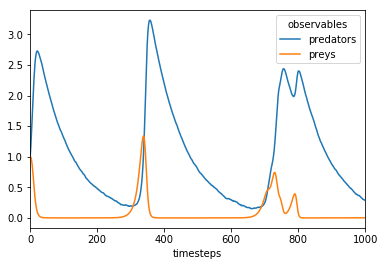

key                                                                        mean  \
prey_birth_rate predator_death_rate initial_pop timesteps observables             
0.1             0.1                 1.0         997       preys        0.002066   
                                                998       predators    0.290889   
                                                          preys        0.002237   
                                                999       predators    0.288315   
                                                          preys        0.002421   

key                                                                         sem  
prey_birth_rate predator_death_rate initial_pop timesteps observables            
0.1             0.1                 1.0         997       preys        0.002066  
                                                998       predators    0.290889  
                                                          preys        0.002237  
                                                999       predators    0.288315  
                                                          preys        0.002421

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob as g
SAVE_PATH_RES = "./dummy/stateval_results/stateval_results"
data = pd.read_pickle(SAVE_PATH_RES)
data.head()
data.head()
data['mean'].unstack('observables').xs(key=(0.1, 0.1, 1.0), level=('prey_birth_rate', 'predator_death_rate', 'initial_pop')).plot()
plt.show()
data.tail()